In [1]:
import gymnasium as gym
import numpy as np
gym.__version__

'0.29.0'

In [2]:
env = gym.make("LunarLander-v2")

From [docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


In [3]:
env.action_space

Discrete(4)


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [4]:
print(env.observation_space.shape)
env.observation_space

(8,)


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

## Taking a step

In [5]:
env.reset()
observation, reward, terminated, truncated, info = env.step(0)

## Reinforcement Learning Objective

Our performance measure: 

$$
J(\theta) = \mathbb{E} \left[ \sum_{t=0}^{T-1}r_{t+1} \right]
$$

and our update rule:

$$
\theta \leftarrow \theta + \frac{\partial}{\partial \theta} J(\theta)
$$

The gradient
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a q_\pi(S_t, a) \nabla \pi (a | S_t, \theta) \right]
$$
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

If we sample $A_t \sim \pi$, then we just replace the expectation over $a$ with the sample $A_t$. So we're doing this swap from expectation to sample:
$$
\sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \rightarrow q_\pi(S_t, A_t)
$$
which then simplifies $\nabla J(\theta)$ to

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ q_\pi(S_t, A_t) \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

and by $\mathbb{E}_\pi [G_t | S_t, A_t] = q_\pi (S_t, A_t)$,

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

We're going to make one more simplification: note that $\nabla \ln x = \frac{\nabla x}{x}$, so
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \nabla \ln \pi (a | S_t, \theta) \right]
$$

Now, we can actually calculate the value in brackets at each time step, and can then use it to update $\theta$:

$$
\theta_{t+1} = \theta_t + \alpha G_t \nabla \ln \pi(A_t | S_t, \theta_t)
$$

We're now going to generate an episode $S_0, A_0, R_1,...,S_{T-1}, A_{T-1}, R_T$.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super().__init__()
        self.w = nn.Linear(obs_size, action_size)
        self.layer = nn.Sequential(
            self.w,
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))

Here is a full episode of the moon landing.

In [7]:
def run_episode(model, env=env):
    observation, _ = env.reset()
    step = 0

    rewards = []
    log_probs = []

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        log_probs.append(_log_probs)

        if terminated:
            observation = env.reset()
            break
        step += 1

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs

rewards, log_probs = run_episode(model)

Now, at the end of the episode, we need to determine $G$, the rewards after the end of each episode.

In [8]:
def discount_rewards(rewards, gamma):
    discounted_rewards = torch.zeros_like(rewards, requires_grad=False)
    R = 0
    for t in reversed(range(len(rewards))):
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
    return discounted_rewards

gamma = 0.99
d_rewards = discount_rewards(rewards, gamma)

In [9]:
def update(model, log_probs, d_rewards, alpha=0.01):
    for (t,(log_prob, reward)) in enumerate(zip(log_probs, d_rewards.tolist())):
        model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in model.parameters():
            if param.grad is not None:
                param.grad = param.grad * reward * gamma**t * alpha # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        model.optimizer.step() # update the weights using the gradients

update(model, log_probs, d_rewards)

And now we'll try it for a bunch of episodes.

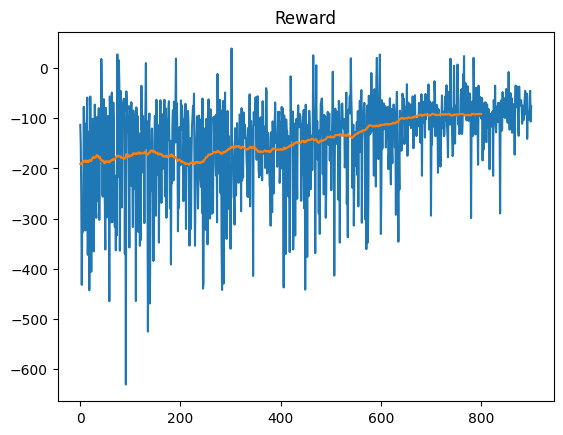

In [10]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(1000):
    rewards, log_probs = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update(model, log_probs, d_rewards)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

It looks like the reward variances are very high, leading to unstable training. We can improve this by using a baseline, which will reduce the variance.

In [11]:
import torch
import torch.nn as nn

# takes in a state, estimates the value of the state v(s)
class StateValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, state):
        return self.layer(torch.tensor(state))
    
model = StateValueNetwork(env.observation_space.shape[0])

observation, _ = env.reset()
model(observation)

tensor([0.0367], grad_fn=<AddBackward0>)

In [12]:
def run_episode(model, env=env):
    observation, _ = env.reset()
    step = 0

    rewards = []
    log_probs = []
    states = [observation]

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        log_probs.append(_log_probs)
        states.append(observation)

        if terminated:
            observation = env.reset()
            break
        step += 1

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, states

model = PolicyNetwork(*network_shape)
rewards, log_probs, states = run_episode(model)

In [13]:
def update_with_baseline(policy_model, state_value_model, log_probs, discounted_rewards, states, alpha=0.01):
    for (t,(log_prob, reward, state)) in enumerate(zip(log_probs, discounted_rewards, states)):
        # update for the state value model
        baseline = state_value_model(state)
        state_value_model.optimizer.zero_grad() # reset the gradients
        baseline.backward()
        for param in state_value_model.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * param.grad
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        state_value_model.optimizer.step() # update the weights using the gradients

        # updates for the policy model
        policy_model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in policy_model.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * gamma**t * param.grad   # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        policy_model.optimizer.step() # update the weights using the gradients

policy_model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
state_value_model = StateValueNetwork(env.observation_space.shape[0])
update_with_baseline(policy_model, state_value_model, log_probs, discount_rewards(rewards, gamma), states)

In [46]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(3000):
    rewards, log_probs, states = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update_with_baseline(policy, state, log_probs, d_rewards, states)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:

        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")
        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

Alright, so something is broken in our implementation of the state value. Let's try to fix it. Good first check is on the gradients. Are they flowing?

In [47]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, f"{100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())}%") for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(state)

[('layer.0.weight', '0.0%'),
 ('layer.0.bias', '0.0%'),
 ('layer.2.weight', '0.0%'),
 ('layer.2.bias', '0.0%')]

So none of our gradients are at 0. That's okay. Let's check how they're distributed. Ideally, we want them to be centered around 0 and have a small variance. This means that the gradients are neither too big nor too small, and that they're both positive and negative.

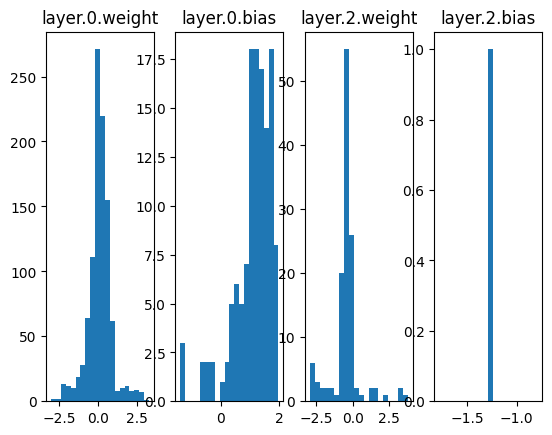

In [53]:

fig, ax = plt.subplots(1, len(list(state.parameters())))
for (i, (name, param)) in enumerate(state.named_parameters()):
    # set the subplot title to be the parameter name
    ax[i].set_title(name)
    # plot the parameter values
    ax[i].hist(param.flatten().detach().numpy(), bins=20)

I think we need to normalize the gradient values, much like batch RMS.

In [54]:
def update_with_baseline(pm, sm, log_probs, discounted_rewards, states, alpha=0.01):
    for (t,(log_prob, reward, state)) in enumerate(zip(log_probs, discounted_rewards, states)):
        # update for the state value model
        baseline = sm(state)
        sm.optimizer.zero_grad() # reset the gradients
        baseline.backward()
        for param in sm.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * param.grad
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        sm.optimizer.step() # update the weights using the gradients

        # updates for the policy model
        pm.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in pm.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * gamma**t * param.grad   # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        pm.optimizer.step() # update the weights using the gradients

p = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
s = StateValueNetwork(env.observation_space.shape[0])
update_with_baseline(p, s, log_probs, discount_rewards(rewards, gamma), states)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

The values network should be converging to the true values of the states. The way in which we can determine this is by looking at the difference between the reward for the state and the value for the state, and they should get closer.

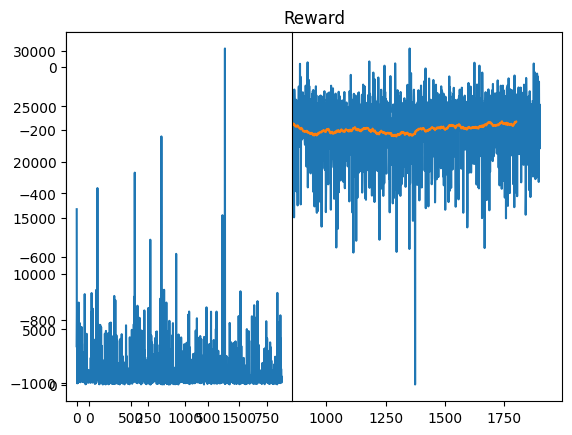

In [73]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

diffs = []
rewards_track = []

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)
# ax2 = fig.add_subplot(1,2,1)

for i in range(2000):
    rewards, log_probs, states = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update_with_baseline(policy, state, log_probs, d_rewards, states)

    rewards_track += [sum(rewards).detach().tolist()]

    v_hat = state(states)[:-1]
    diffs += [((d_rewards - v_hat)**2).mean().detach().tolist()]

    if i % 100 == 0:
        ax1.clear()
        ax1.plot(rewards_track)
        ax1.set_title("Reward")
        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax1.plot(smoothed)
        
        ax2.clear()
        ax2.plot(diffs)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break